# House Price Prediction Project
This notebook walks through the process of predicting house prices using regression analysis. It includes data loading, preprocessing, feature engineering, model training, and prediction.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

## Exploratory Data Analysis (EDA)

In [3]:
# Basic overview
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Distribution of Sale Price

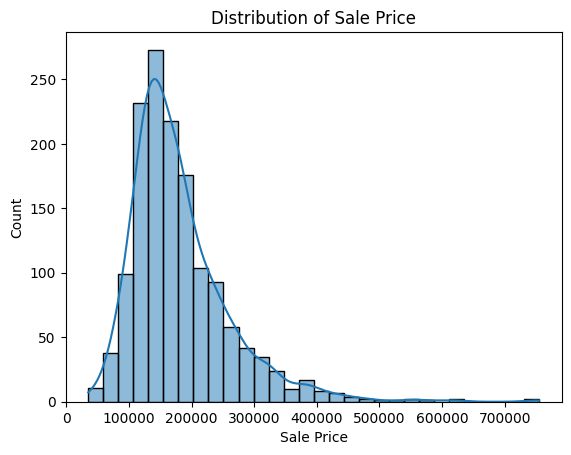

In [4]:
y = train["SalePrice"]
sns.histplot(y, kde=True, bins=30)
plt.title("Distribution of Sale Price")
plt.xlabel("Sale Price")
plt.ylabel("Count")
plt.show()

### Correlation Heatmap of Numerical Features

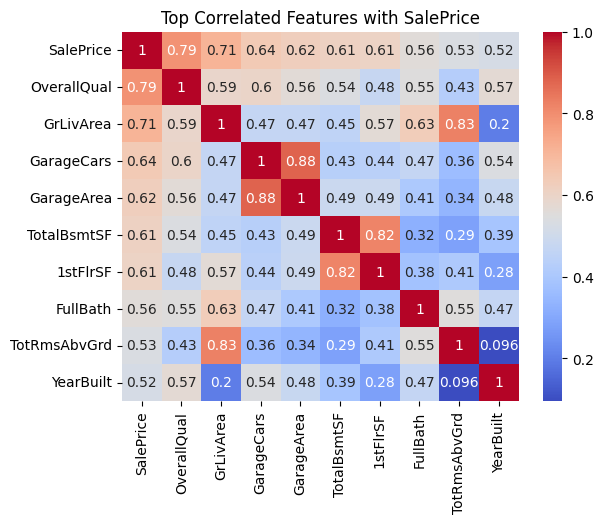

In [6]:
numerical_cols = train.select_dtypes(include=['int64', 'float64']).columns
corr = train[numerical_cols].copy()
corr['SalePrice'] = y
corr_matrix = corr.corr()
top_corr_features = corr_matrix['SalePrice'].abs().sort_values(ascending=False).head(10).index
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features], annot=True, cmap='coolwarm')
plt.title("Top Correlated Features with SalePrice")
plt.show()

### Feature Importance from Random Forest

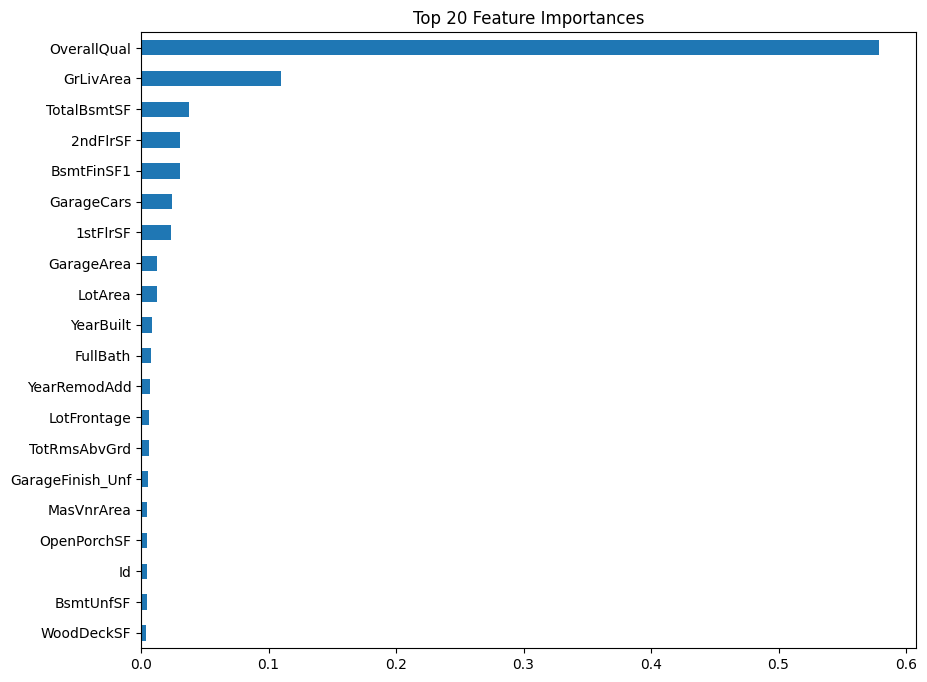

In [11]:
# Get feature importances from the trained model
categorical_cols = X.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
model.fit(X, y)

feature_names = model.named_steps["preprocessor"].transformers_[0][2].tolist() + \
                list(model.named_steps["preprocessor"].transformers_[1][1]
                     .named_steps['onehot'].get_feature_names_out(categorical_cols))
importances = model.named_steps["regressor"].feature_importances_

# Create DataFrame
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
feat_importances.plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

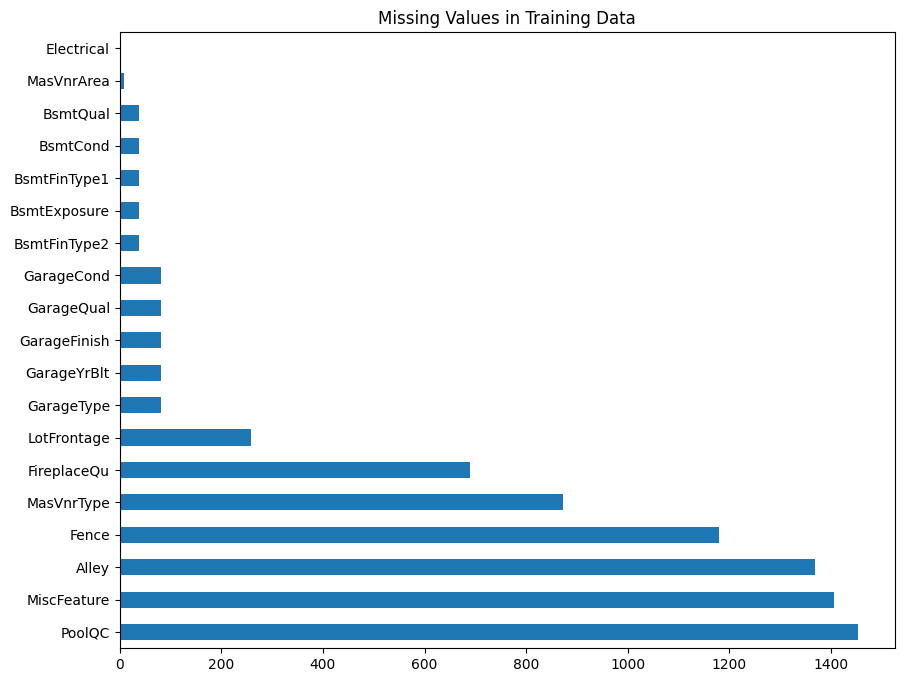

In [12]:
# Check missing values
missing = train.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing.plot(kind='barh', figsize=(10,8))
plt.title("Missing Values in Training Data")
plt.show()

## Data Preprocessing

In [13]:
# Separate target
y = train["SalePrice"]
train.drop("SalePrice", axis=1, inplace=True)
all_data = pd.concat([train, test], sort=False)

# Handle missing values
categorical_cols = all_data.select_dtypes(include=["object"]).columns
numerical_cols = all_data.select_dtypes(exclude=["object"]).columns

# Imputers
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine preprocessing
preprocessor = ColumnTransformer([
    ("num", numerical_transformer, numerical_cols),
    ("cat", categorical_transformer, categorical_cols)
])

## Model Training

In [14]:
# Train-test split from training set
X = train
X_test = test
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train model
model.fit(X_train, y_train)

# Validate
preds = model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print(f"Validation RMSE: {rmse:.2f}")

Validation RMSE: 28527.52


## Predict on Test Set and Prepare Submission

In [15]:
# Predict
final_preds = model.predict(X_test)

# Submission
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": final_preds
})
submission.to_csv("submission.csv", index=False)
submission.head()

,Id,SalePrice
0,1461,131281.50
1,1462,152826.25
2,1463,178030.50
3,1464,187829.02
4,1465,206028.79


In [10]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 783.8 kB/s eta 0:00:00 kB/s eta 0:00:012
